# Pipeline: Lane finding on videos
We show an end to end processing pipeline from raw uncalibrated videos to lanes including lane curvature etc

### Read a video file, dummy-process it, and save it as output
We start with a pipeline which does nothing but read the video, dummy-process single images, and save the new output.

In [1]:
def process_image_dummy(image):
    return image

In [2]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

#input_name = 'challenge_video.mp4'
input_name = 'project_video.mp4'
output_dir = 'output_videos'
# .subclip for quick test, args are start and stop in seconds
#input_clip = VideoFileClip(input_name).subclip(0,5)
input_clip = VideoFileClip(input_name)
output_clip = input_clip.fl_image(process_image_dummy) 
%time output_clip.write_videofile(os.path.join(output_dir,input_name), audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_videos/project_video.mp4.
Moviepy - Writing video output_videos/project_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/project_video.mp4
CPU times: user 2.61 s, sys: 6.48 s, total: 9.09 s
Wall time: 39.1 s


## Distortion correction
Read in raw uncalibrated images and correct for camera lens distortions

In [3]:
import cv2
import pickle, pprint

# Camera matrix and distortion coefficients obtained in 'Camera Calibration' notebook
calib_file = open('camera_calib.pickle','rb')
calib_dict = pickle.load(calib_file)
print('Read camera calibration objects:')
pprint.pprint(calib_dict)
calib_file.close()

#cameraMatrix = [[1.15777942e+03, 0.00000000e+00, 6.67111049e+02],
# [0.00000000e+00, 1.15282305e+03, 3.86129069e+02],
# [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]
#distCoeffs = [[-0.24688833, -0.02372814, -0.00109843, 0.00035105, -0.00259138]]

def cal_undistort(img, mtx=calib_dict['cameraMatrix'], dist=calib_dict['distCoeffs']):
    undist = cv2.undistort(img, mtx, dist)
    return undist


Read camera calibration objects:
{'cameraMatrix': array([[1.15777942e+03, 0.00000000e+00, 6.67111049e+02],
       [0.00000000e+00, 1.15282305e+03, 3.86129069e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'distCoeffs': array([[-0.24688833, -0.02372814, -0.00109843,  0.00035105, -0.00259138]])}


In [4]:
# Undistort video
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

#input_name = 'challenge_video'
input_name = 'project_video'
output_dir = 'output_videos'
# .subclip for quick test, args are start and stop in seconds
#input_clip = VideoFileClip(input_name+'.mp4').subclip(0,5)
input_clip = VideoFileClip(input_name+'.mp4')
output_clip = input_clip.fl_image(cal_undistort) 
%time output_clip.write_videofile(os.path.join(output_dir,input_name+'_undist'+'.mp4'), audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_videos/project_video_undist.mp4.
Moviepy - Writing video output_videos/project_video_undist.mp4



Moviepy - Done !
Moviepy - video ready output_videos/project_video_undist.mp4
CPU times: user 1min 33s, sys: 6.34 s, total: 1min 39s
Wall time: 47 s


In [5]:
%%bash
ls output_videos
ls -lh output_videos/challenge_video.mp4

challenge_video.mp4
challenge_video_birds_lane.mp4
challenge_video_birds_pic.mp4
challenge_video_fitlanes.mp4
challenge_video_lanepixels.mp4
challenge_video_undist.mp4
project_video.mp4
project_video_birds_lane.mp4
project_video_birds_pic.mp4
project_video_fitlanes.mp4
project_video_fitlanes_noprior.mp4
project_video_lanepixels.mp4
project_video_origlanes.mp4
project_video_undist.mp4
-rwxrwxrwx 1 hbeck hbeck 4.8M Jul 30 17:24 output_videos/challenge_video.mp4


In [6]:
%%HTML
<video width="320" height="240" controls>
  <!-- <source src="output_videos/challenge_video.mp4" type="video/mp4"> -->
  <source src="output_videos/project_video.mp4" type="video/mp4">
</video>
<video width="320" height="240" controls>
    <!-- <source src="output_videos/challenge_video_undist.mp4" type="video/mp4"> -->
    <source src="output_videos/project_video_undist.mp4" type="video/mp4">
</video>

## Lane Pixels
We use a combination of various gradients, color transforms, et cetera to identify pixels which belong to lane markings

In [7]:
import numpy as np
import cv2

# Function to select pixels belonging to lanes
def lane_pixels(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary,combined_binary
    

In [8]:
# Apply on video
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

def process_image(img):
    # Undistort
    undistorted = cal_undistort(img, calib_dict['cameraMatrix'], calib_dict['distCoeffs'])
    
    # Lane pixels
    sep, combined = lane_pixels(undistorted,s_thresh=(180, 255), sx_thresh=(30, 120))
    
    return sep
    
#input_name = 'challenge_video'
input_name = 'project_video'
output_dir = 'output_videos'
# .subclip for quick test, args are start and stop in seconds
#input_clip = VideoFileClip(input_name+'.mp4').subclip(0,5)
input_clip = VideoFileClip(input_name+'.mp4')
output_clip = input_clip.fl_image(process_image) 
%time output_clip.write_videofile(os.path.join(output_dir,input_name+'_lanepixels'+'.mp4'), audio=False)



t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_videos/project_video_lanepixels.mp4.
Moviepy - Writing video output_videos/project_video_lanepixels.mp4



Moviepy - Done !
Moviepy - video ready output_videos/project_video_lanepixels.mp4
CPU times: user 2min 46s, sys: 9.09 s, total: 2min 55s
Wall time: 1min 37s


In [9]:
%%bash
ls -lh output_videos

total 155M
-rwxrwxrwx 1 hbeck hbeck 4.8M Jul 30 17:24 challenge_video.mp4
-rwxrwxrwx 1 hbeck hbeck 4.0M Jul 30 17:36 challenge_video_birds_lane.mp4
-rwxrwxrwx 1 hbeck hbeck 3.6M Jul 30 17:36 challenge_video_birds_pic.mp4
-rwxrwxrwx 1 hbeck hbeck 5.5M Aug 10 15:06 challenge_video_fitlanes.mp4
-rwxrwxrwx 1 hbeck hbeck  12M Jul 30 17:24 challenge_video_lanepixels.mp4
-rwxrwxrwx 1 hbeck hbeck 4.3M Jul 30 17:24 challenge_video_undist.mp4
-rwxrwxrwx 1 hbeck hbeck  18M Aug 10 15:34 project_video.mp4
-rwxrwxrwx 1 hbeck hbeck 9.7M Aug  9 14:24 project_video_birds_lane.mp4
-rwxrwxrwx 1 hbeck hbeck  10M Aug  9 14:22 project_video_birds_pic.mp4
-rwxrwxrwx 1 hbeck hbeck 338K Aug 10 15:22 project_video_fitlanes.mp4
-rwxrwxrwx 1 hbeck hbeck  13M Aug 10 12:49 project_video_fitlanes_noprior.mp4
-rwxrwxrwx 1 hbeck hbeck  44M Aug 10 15:36 project_video_lanepixels.mp4
-rwxrwxrwx 1 hbeck hbeck  14M Aug 10 15:25 project_video_origlanes.mp4
-rwxrwxrwx 1 hbeck hbeck  16M Aug 10 15:35 project_video_undist.mp4


In [10]:
%%HTML
<video width="320" height="240" controls>
    <!-- <source src="output_videos/challenge_video.mp4" type="video/mp4"> -->
    <source src="output_videos/project_video.mp4" type="video/mp4">
</video>
<video width="320" height="240" controls>
    <!-- <source src="output_videos/challenge_video_lanepixels.mp4" type="video/mp4"> -->
    <source src="output_videos/project_video_lanepixels.mp4" type="video/mp4">
</video>

## Warp image: bird's eye view
Warp the image such that it is represented in a bird's eye view

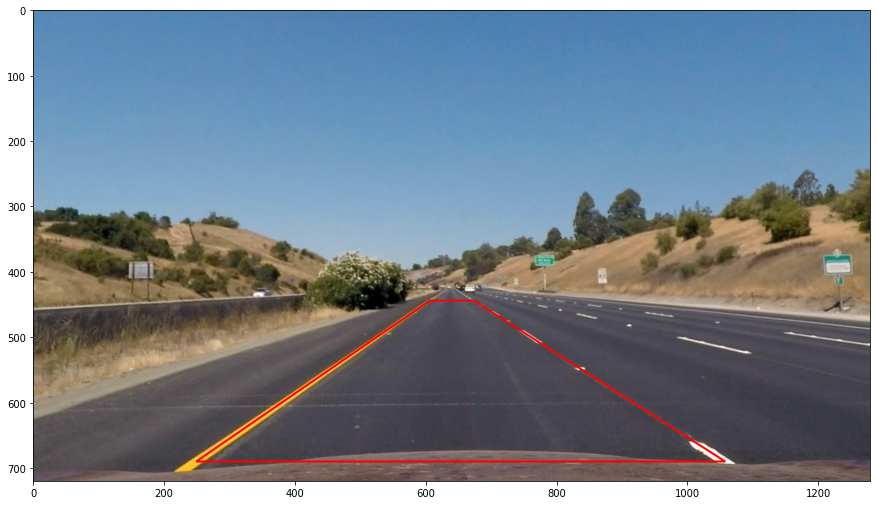

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# Looking at one of the undistorted images, we find this trapeziod 
# 249 690
# 1058 690
# 606 444
# 674 444

#
# Visualize our trapezoid
#

# Read image
img = cv2.imread('output_images/straight_lines1_cal.jpg')
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

trapezoid = np.float32([(249,690),(1058,690),(674,444),(606,444)])

# Show
fig, ax = plt.subplots(nrows=1, ncols=1,sharex=True,sharey=True,figsize=(15,30))
ax.imshow(img)
ax.add_patch(patches.Polygon(xy=trapezoid, fill=False,linewidth=2,color='red'))


In [12]:
def get_warp_matrix():
    '''
    Our warp matrix
    '''
    # Image properties
    height = 720
    width = 1280

    # Our trapeziod in the source image
    src = np.float32([[249,690],[1058,690],[674,444],[606,444]])
        
    # Define destination for the source trapezoid
    dst = np.copy(src)
    # .. only lower half of image
    dst[:,1] = (dst[:,1] - height/2)*2
    # .. bird's eye
    dst[3,0] = dst[0,0]
    dst[2,0] = dst[1,0]
    
    #     # Squeeze all points by 50px or so in lateral direction
    #     squeeze = 200
    #     #print('Before squeeze: ',dst)
    #     # left points
    #     dst[np.array([0,3]), np.array([0,0])] = dst[np.array([0,3]), np.array([0,0])] + squeeze
    #     # right points
    #     dst[np.array([1,2]), np.array([0,0])] = dst[np.array([1,2]), np.array([0,0])] - squeeze
    #     #print('After squeeze: ',dst)

    # Squeeze all points by 50px or so in lateral direction,
    # but squueze while respecting camera center :) 
    squeeze = 200
    #print('Before squeeze: ',dst)
    
    # Get the squeeze wrt the center
    img_center = width//2
    left_dist = np.abs(img_center - dst[0,0])
    right_dist = np.abs(img_center- dst[1,0])
    mean_dist = (left_dist + right_dist)/2.0
    left_squeeze = int(squeeze *left_dist/mean_dist)
    right_squeeze = int(squeeze *right_dist/mean_dist)
    
    # left points
    dst[np.array([0,3]), np.array([0,0])] = dst[np.array([0,3]), np.array([0,0])] + left_squeeze
    # right points
    dst[np.array([1,2]), np.array([0,0])] = dst[np.array([1,2]), np.array([0,0])] - right_squeeze
    #print('After squeeze: ',dst)
    
    
    # Move the bottom dest points down
    # Story is, we don't fit a linear parameter, so we need to get the 
    # longitudinal zero position right.. no downward shift is too little
    # shifting to height -5 is too much..
    #print('Before shift:',dst[np.array([0,1]), np.array([1,1])])
    dst[np.array([0,1]), np.array([1,1])] = height - 20
    #print('After shift:',dst[np.array([0,1]), np.array([1,1])])
    # Get the transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)

    return M

In [13]:
def birds_eye(img):
    '''
    Warps an image to birds eye view
    '''
    # Image properties
    height = img.shape[0]
    width = img.shape[1]

    # Get warp matrix
    M = get_warp_matrix()
    
    # Do warp
    warped = cv2.warpPerspective(img, M, (width,height))   
    
    return warped

In [14]:
# Apply on video
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

# The camera image in bird's eye view
def process_image_birds_pic(img):
    # Undistort
    undistorted = cal_undistort(img, calib_dict['cameraMatrix'], calib_dict['distCoeffs'])
    
    # Lane pixels
    sep, combined = lane_pixels(undistorted,s_thresh=(180, 255), sx_thresh=(30, 120))
    
    # warp
    warp = birds_eye(undistorted)
    #warp_lanes = birds_eye(combined)
    
    return warp

# The lane pixels in bird's eye view
def process_image_birds_lane(img):
    # Undistort
    undistorted = cal_undistort(img, calib_dict['cameraMatrix'], calib_dict['distCoeffs'])
    
    # Lane pixels
    sep, combined = lane_pixels(undistorted,s_thresh=(180, 255), sx_thresh=(30, 120))
    
    # warp
    #warp = birds_eye(undistorted)
    warp_lanes = birds_eye(sep)
    
    return warp_lanes
    
#input_name = 'challenge_video'
input_name = 'project_video'
output_dir = 'output_videos'
# .subclip for quick test, args are start and stop in seconds
#input_clip = VideoFileClip(input_name+'.mp4').subclip(0,5)
input_clip = VideoFileClip(input_name+'.mp4')
output_clip_pic = input_clip.fl_image(process_image_birds_pic) 
%time output_clip_pic.write_videofile(os.path.join(output_dir,input_name+'_birds_pic'+'.mp4'), audio=False)
output_clip_lane = input_clip.fl_image(process_image_birds_lane) 
%time output_clip_lane.write_videofile(os.path.join(output_dir,input_name+'_birds_lane'+'.mp4'), audio=False)



t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_videos/project_video_birds_pic.mp4.
Moviepy - Writing video output_videos/project_video_birds_pic.mp4



Moviepy - Done !
Moviepy - video ready output_videos/project_video_birds_pic.mp4
CPU times: user 3min 38s, sys: 57 s, total: 4min 35s
Wall time: 3min 2s


t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_videos/project_video_birds_lane.mp4.
Moviepy - Writing video output_videos/project_video_birds_lane.mp4



Moviepy - Done !
Moviepy - video ready output_videos/project_video_birds_lane.mp4
CPU times: user 3min 48s, sys: 56.8 s, total: 4min 45s
Wall time: 2min 51s


In [15]:
%%HTML
<video width="320" height="240" controls>
    <!-- <source src="output_videos/challenge_video_birds_pic.mp4" type="video/mp4"> -->
    <source src="output_videos/project_video_birds_pic.mp4" type="video/mp4"> 
</video>
<video width="320" height="240" controls>
    <!-- <source src="output_videos/challenge_video_birds_lane.mp4" type="video/mp4"> -->
    <source src="output_videos/project_video_birds_lane.mp4" type="video/mp4">
</video>

# Fit lanes - no prior
We fit a polynomial to selected lane pixels

In [16]:
                    
def get_pixels_no_prior(img,x_window=100,n_y_windows=5):
    '''
    Find the lane markings without prior 
    '''
   
    # For videos, we pass separate lane pixels, i.e. rgb. 
    # Need to combine them here
    # Turn RGB into binary grayscale
    # print('img.shape: ',img.shape) #--> (720, 1280, 3)
    img_bin = np.zeros(shape=img.shape[0:2])
    # print('img_bin.shape: ',img_bin.shape) #--> (720, 1280)
    img_bin[(img[:,:,0]==255) | (img[:,:,1]==255) | (img[:,:,2]==255)] = 1
    img=img_bin
    
    # Get the x position of the left lane, 
    # as the weighted mean of all lane pixels in lower half 
    img_height = img.shape[0]
    y_half = img_height//2
    weights = np.linspace(0.,1.,y_half)
    histogram = np.dot(img[y_half:,:].T,weights)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)

    # With narrow projection
    #leftx_base = np.argmax(histogram[:midpoint])
    #rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # With wide projection, i.e. we see left and right lanes too
    leftx_base = np.argmax(histogram[midpoint//2:midpoint]) + midpoint//2
    rightx_base = np.argmax(histogram[midpoint:midpoint*3//2]) + midpoint
    
    
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img, img, img))
    out_img = out_img*255
 
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = x_window
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Momentum of the update
    leftx_momentum = 0
    rightx_momentum = 0
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height

        # Don't simply use the previous position but use
        # the local curvature as well 
        leftx_current = leftx_current + np.mean((leftx_momentum,rightx_momentum),dtype=int)
        rightx_current = rightx_current + np.mean((leftx_momentum,rightx_momentum),dtype=int)
        
        ### The four boundaries of the window ###
        win_xleft_low = leftx_current - margin  
        win_xleft_high = leftx_current + margin 
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy>win_y_low) & (nonzeroy<=win_y_high) &
                          (nonzerox>win_xleft_low) & (nonzerox<=win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy>win_y_low) & (nonzeroy<=win_y_high) &
                           (nonzerox>win_xright_low) & (nonzerox<=win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        
        ### If we found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if(len(good_left_inds) > minpix):
            old = leftx_current
            leftx_current = np.mean(nonzerox[good_left_inds],dtype=int)
            leftx_momentum = leftx_momentum + leftx_current - old
            #print('leftx_current: ',leftx_current)
        else:
            leftx_momentum = int(leftx_momentum*1.2) # empiric, should do some math here
        if(len(good_right_inds) > minpix):
            old = rightx_current
            rightx_current = np.mean(nonzerox[good_right_inds],dtype=int)
            rightx_momentum = rightx_momentum + rightx_current - old
            #print('rightx_current: ',rightx_current)
        else:
            rightx_momentum = int(rightx_momentum*1.2) # empiric, should do some math here
        

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


In [17]:
from scipy.optimize import curve_fit

def fit_fct(y,a1,a2,c):
    '''
    Takes as input an array of values and fits 
    the first part with 
    x = a1    + c*y**2
    and the second
    x = a1+a2 + c*y**2
    The two parts are distiguished by a bool array
    Allows to fit two lines at once
    '''
    y,b = y
    b = b.astype(dtype=bool)
    x = a1 + c*(y**2)
    x[b] = x[b] + a2
    
    return x
    

def fit_polynomial(leftx, lefty, rightx, righty, img):
    '''
    simultaneously fits two polynomials with shared paramaters:
    leftx = a1 + c*lefty**2
    rightx = a1+a2 + c*lefty**2
    and returns
    a1, a2, c
    '''
    #
    # Our assumption is: the road only has one curvature
    #
    
    # curve fit takes x as (k,M)-shaped array,
    # we combine left and right x and y
    # we add to y whether it's left or right
    x = np.concatenate((leftx,rightx))
    y = np.concatenate((lefty,righty))
    y = img.shape[0] - y
    b = np.zeros_like(x,dtype=bool)
    b[len(leftx):] = True
    yb = np.vstack((y,b))
    # Do the fit
    p = np.array((300,800,0))
    
    # Standard fit without error
    #p = curve_fit(fit_fct,y,x,p)
    
    # Fit with error increasing longitudinally
    p = curve_fit(fit_fct,yb,x,p,sigma=y+1)
    
    
    #print(p)

    return p

In [18]:
# Apply on video
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

# The lane pixels in bird's eye view
def process_image(img):
    # Undistort
    undistorted = cal_undistort(img, calib_dict['cameraMatrix'], calib_dict['distCoeffs'])
    
    # Lane pixels
    sep, combined = lane_pixels(undistorted,s_thresh=(180, 255), sx_thresh=(30, 120))
    
    # warp
    #warp = birds_eye(undistorted)
    warp_lanes = birds_eye(sep)
    
    #
    # TODO use fit if it exists
    #
    # Get pixels without fit
    leftx, lefty, rightx, righty, img_windows = get_pixels_no_prior(warp_lanes,x_window=100)
    # fit
    params,params_e = fit_polynomial(leftx, lefty, rightx, righty, warp_lanes)    
    #  visualize lane pixels 
    img_windows[lefty, leftx] = [255, 0, 0]
    img_windows[righty, rightx] = [0, 0, 255]
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warp_lanes.shape[0]-1, warp_lanes.shape[0] )
    left_fitx  = params[0]           + params[2]*(warp_lanes.shape[0]-ploty)**2 
    right_fitx = params[0]+params[1] + params[2]*(warp_lanes.shape[0]-ploty)**2    

    # Plots the left and right polynomials on the lane lines
    left_points = np.stack((left_fitx, ploty), axis=1)
    right_points = np.stack((right_fitx, ploty), axis=1)
    cv2.polylines(img_windows, np.int32([left_points]), isClosed=False, color=(255, 255, 0)) # color = yellow
    cv2.polylines(img_windows, np.int32([right_points]), isClosed=False, color=(255, 255, 0)) # color = yellow
    
    return img_windows
    
#input_name = 'challenge_video'
input_name = 'project_video'
output_dir = 'output_videos'
# .subclip for quick test, args are start and stop in seconds
#input_clip = VideoFileClip(input_name+'.mp4').subclip(0,5)
input_clip = VideoFileClip(input_name+'.mp4')
output_clip = input_clip.fl_image(process_image) 
%time output_clip.write_videofile(os.path.join(output_dir,input_name+'_fitlanes_noprior'+'.mp4'), audio=False)


t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_videos/project_video_fitlanes_noprior.mp4.
Moviepy - Writing video output_videos/project_video_fitlanes_noprior.mp4



Moviepy - Done !
Moviepy - video ready output_videos/project_video_fitlanes_noprior.mp4
CPU times: user 9min 31s, sys: 6min 36s, total: 16min 8s
Wall time: 7min 36s


In [19]:
%%HTML
<video width="320" height="240" controls>
  <!-- <source src="output_videos/challenge_video_birds_pic.mp4" type="video/mp4"> -->
    <source src="output_videos/project_video_birds_pic.mp4" type="video/mp4">
</video>
<video width="320" height="240" controls>
  <!-- <source src="output_videos/challenge_video_fitlanes_noprior.mp4" type="video/mp4"> -->
    <source src="output_videos/project_video_fitlanes_noprior.mp4" type="video/mp4">
</video>

# Fit lanes - with prior
We fit a polynomial to selected lane pixels using the previous fit to select pixels

In [20]:
# Get pixels with a fit
# leftx, lefty, rightx, righty, img_windows = get_pixels_no_prior(warp_lanes,x_window=100)
def get_pixels_prior(img, params, x_window=50):
    
    #
    # Select all pixels within x_window px around the existing fit 
    # 
    
    # For videos, we pass separate lane pixels, i.e. rgb. 
    # Need to combine them here
    # Turn RGB into binary grayscale
    # print('img.shape: ',img.shape) #--> (720, 1280, 3)
    img_bin = np.zeros(shape=img.shape[0:2])
    # print('img_bin.shape: ',img_bin.shape) #--> (720, 1280)
    img_bin[(img[:,:,0]==255) | (img[:,:,1]==255) | (img[:,:,2]==255)] = 1
    img=img_bin

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img, img, img))
    out_img = out_img*255

    # Get all non-zero pixels
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Coordinate transformation: our y is zero at the bottom
    y = img.shape[0] - nonzeroy
    
    # For all y, derive the corresponding x of the lane fits
    left_fitx  = params[0]           + params[2]*y**2 
    right_fitx = params[0]+params[1] + params[2]*y**2    

    # Identify the nonzero pixels in x and y within the window ###
    left_lane_inds = ((nonzerox>left_fitx-x_window) 
                      & (nonzerox<=left_fitx+x_window)).nonzero()[0]
    right_lane_inds = ((nonzerox>right_fitx-x_window) 
                      & (nonzerox<=right_fitx+x_window)).nonzero()[0]
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    #
    # Visualize
    #
    
    # Visualize our search window
    ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0] )
    left_fitx_lo  = params[0]           +params[2]*(out_img.shape[0]-ploty)**2 -x_window
    left_fitx_hi  = params[0]           +params[2]*(out_img.shape[0]-ploty)**2 +x_window
    right_fitx_lo = params[0]+params[1] +params[2]*(out_img.shape[0]-ploty)**2 -x_window
    right_fitx_hi = params[0]+params[1] +params[2]*(out_img.shape[0]-ploty)**2 +x_window

    # Plots the left and right polynomials on the lane lines
    left_points_lo  = np.stack((left_fitx_lo,  ploty), axis=1)
    left_points_hi  = np.stack((left_fitx_hi,  ploty), axis=1)
    right_points_lo = np.stack((right_fitx_lo, ploty), axis=1)
    right_points_hi = np.stack((right_fitx_hi, ploty), axis=1)
    cv2.polylines(out_img, np.int32([left_points_lo]), isClosed=False, color=(0, 255, 0)) # color = green
    cv2.polylines(out_img, np.int32([left_points_hi]), isClosed=False, color=(0, 255, 0)) # color = green
    cv2.polylines(out_img, np.int32([right_points_lo]), isClosed=False, color=(0, 255, 0)) # color = green
    cv2.polylines(out_img, np.int32([right_points_hi]), isClosed=False, color=(0, 255, 0)) # color = green

    return leftx, lefty, rightx, righty, out_img
    

In [21]:
# Apply on video
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

# Whether we have a successful fit
has_fit = False
# Parameters of the fit
params = [999.,999.,999.]

# The lane pixels in bird's eye view
def process_image(img):
    # reference global var
    global has_fit
    global params
    
    # Undistort
    undistorted = cal_undistort(img, calib_dict['cameraMatrix'], calib_dict['distCoeffs'])
    
    # Lane pixels
    sep, combined = lane_pixels(undistorted,s_thresh=(180, 255), sx_thresh=(30, 120))
    
    # warp
    #warp = birds_eye(undistorted)
    warp_lanes = birds_eye(sep)
    
    #
    # Select pixels to fit
    #
    
    if(has_fit==True):
        # Get pixels with fit
        leftx, lefty, rightx, righty, img_windows = get_pixels_prior(warp_lanes, params, x_window=50)
        # Reset fit if left or right is bad.. ..say less than 20 pixels for a bad frame
        if(leftx.shape[0]<10 or rightx.shape[0]<10):
                print('Reset: leftx.shape:',leftx.shape,', rightx.shape:',rightx)
                has_fit=False
    if(has_fit==False):
        # Get pixels without fit
        leftx, lefty, rightx, righty, img_windows = get_pixels_no_prior(warp_lanes,x_window=100)
        has_fit = True
    # fit
    params,params_e = fit_polynomial(leftx, lefty, rightx, righty, warp_lanes)

    #  visualize lane pixels 
    img_windows[lefty, leftx] = [255, 0, 0]
    img_windows[righty, rightx] = [0, 0, 255]
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warp_lanes.shape[0]-1, warp_lanes.shape[0] )
    left_fitx  = params[0]           + params[2]*(warp_lanes.shape[0]-ploty)**2 
    right_fitx = params[0]+params[1] + params[2]*(warp_lanes.shape[0]-ploty)**2    

    # Plots the left and right polynomials on the lane lines
    left_points = np.stack((left_fitx, ploty), axis=1)
    right_points = np.stack((right_fitx, ploty), axis=1)
    cv2.polylines(img_windows, np.int32([left_points]), isClosed=False, color=(255, 255, 0)) # color = yellow
    cv2.polylines(img_windows, np.int32([right_points]), isClosed=False, color=(255, 255, 0)) # color = yellow
    
    return img_windows
    
#input_name = 'challenge_video'
input_name = 'project_video'
output_dir = 'output_videos'
# .subclip for quick test, args are start and stop in seconds
#input_clip = VideoFileClip(input_name+'.mp4').subclip(0,5)
input_clip = VideoFileClip(input_name+'.mp4')
output_clip = input_clip.fl_image(process_image) 
%time output_clip.write_videofile(os.path.join(output_dir,input_name+'_fitlanes'+'.mp4'), audio=False)


t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_videos/project_video_fitlanes.mp4.
Moviepy - Writing video output_videos/project_video_fitlanes.mp4



Moviepy - Done !
Moviepy - video ready output_videos/project_video_fitlanes.mp4
CPU times: user 4min 34s, sys: 1min 36s, total: 6min 10s
Wall time: 4min 16s


In [22]:
%%HTML
<video width="320" height="240" id="vid1" controls>
  <!-- <source src="output_videos/challenge_video_birds_pic.mp4" type="video/mp4"> -->
    <source src="output_videos/project_video_birds_pic.mp4" type="video/mp4">
</video>
<video width="320" height="240" id="vid2" controls>
  <!-- <source src="output_videos/challenge_video_fitlanes.mp4" type="video/mp4"> -->
    <source src="output_videos/project_video_fitlanes_noprior.mp4" type="video/mp4">
</video>
<video width="320" height="240" id="vid3" controls>
  <!-- <source src="output_videos/challenge_video_fitlanes.mp4" type="video/mp4"> -->
    <source src="output_videos/project_video_fitlanes.mp4" type="video/mp4">
</video>

## Determine Curve Radius
We use 
https://en.wikipedia.org/wiki/Radius_of_curvature#Formula <br/>
$\rho = \frac{|1+(f'(t))^2 |^{3/2}}{|f''(t)|}$, with <br/>
$f(t) = a1 (+a2)    + c*t^2$ <br/>
$f'(t) = 2c*t$ <br/>
$f''(t) = 2c$ <br/>
&rightarrow; $\rho(t) = \frac{|1+(2ct)^2|^{3/2}}{|2c|}$ <br/>
&rightarrow; $\rho(t=0) = \frac{1}{|2c|}$


#### Unit conversion of c
$f(t) [xpx] = ... + c [???] * (t [ypx])^2$ <br/>
$[xpx] = [???]* [ypx]^2$ <br/>
$[???] = [xpx]/[ypx]^2 $ <br/> 
&rightarrow; unit of c is xpx/ypx^2 <br/>


c' [m/m^2] = c [xpx/ypx^2]* m_per_xpixel / m_per_ypixel^2 

In [23]:
def get_radius(params):
    '''
    takes in params a1, a2, c
    returns radius rho = 1/|2c|
    '''
    _,_,c=params
    
    # pixels to meters:
    # lane markings
    #  - length 10feet = 3.048m 
    #  - gap 30feet = 9.144m
    # lane width
    #  - 12 feet = 3.658m 
    #
 

    #
    #  This is on the narrow bird's eye 
    #
    # we measure 
    #  * straight_lines1_bird * 
    # lane width 1057-251=806; 1061-243=818 
    # marker 568-530=38; 445-406=39
    # gap 531-444=87; 655-568=87
    #
    #                         <-10ft-><-----30ft-----> 
    #  - length: 38 and 39    ||||||||                ||||||||
    #  - gap: 87 and 87       
    # --> 30feet = (38*3 +39*3 +87+87)/4 = (114+117+87+87)/4 = 405/4 = 101
    # 9.144m = 101 pixel 
    # Above must be wrong!! Totally inconsistent values. How about?
    # This would make sense looking at the left lane markings of straight_lines1_bird.jpg
    #   <-10ft->
    #       <---------30ft---------> 
    #       <5f><------20ft----><5f>  
    #   ||||||||                ||||||||
    # --> 20feet = (38*2 +39*2 + 87 +87)/4 = (76+78+87+87)/4=328/4 =82
    # 6.096m = 82 pixel 
    # 
    #  * straight_lines2_bird * 
    # marker 10ft: 523-478=45; 397-351=46
    # 
    # udacity: 30m/720 pixel
    #
    # --> Overall, sth seems off. let's go with average of the markers
    # 10ft = (45+46+38+39)/4 ypixels = 168/4 ypixels = 42 ypixels = 3.048m 
    # --> m_per_ypixel = 3.048/42 m/ypixel 
    m_per_ypixel = 3.048/42
    
    #  - width
    # 12ft = (806+818)/2 xpixel = 812 xpixel = 3.658m 
    m_per_xpixel = 3.658/812
    
    
    #This is on the wide bird's eye 
    # with a sqeeze of 200px left and right
    #  * straight lines 1 bird
    # marker length 568-531 = 37
    # lane width 858-450 = 408
    m_per_ypixel = 3.048/37
    m_per_xpixel = 3.658/408
    
    # This is on birds eye 
    # with a sqeeze of weighted 200px left and right
    # and a shift down to height -5
    #  * straight lines 1 bird
    # marker length 613-572 = 41
    # lane width 882-443 = 449
    m_per_ypixel = 3.048/41
    m_per_xpixel = 3.658/449

    # with a sqeeze of weighted 200px left and right
    # and a shift down to height -20
    #  * straight lines 1 bird
    # marker length 600-559 = 41
    # lane width 852-442 = 410
    m_per_ypixel = 3.048/41
    m_per_xpixel = 3.658/410

    cm = c * m_per_xpixel / m_per_ypixel**2
    
    # This evaluates at t = 0
    #return 1/(2*abs(cm))
    
    # This evaluates in the center
    # no difference, gives factor 1.005
    #print('factor is ',(1+(2*cm*360*m_per_ypixel)**2)**(3/2))
    return (1+(2*cm*360*m_per_ypixel)**2)**(3/2)/(2*abs(cm))

In [24]:
def get_position(params,img):
    '''
    retrieves the position of the car in the lane
    with respect to its center in meters
    
    |       |
    |       |
    |   .   |
    -1  0   1
    
    '''
    
    a1,a2,_=params
    
    # The midpoint of the image is the car's position
    car_pos_px = img.shape[1]/2
    # The center of the lane is mean of the two lane 
    # demarcations
    lane_center_px = a1+a2/2
    
    # Position of the car in the lane in pixels
    pos_px = car_pos_px - lane_center_px
    # Convert x pixels in meters
    #rel_pos_m = pos_px * 3.658/408
    #rel_pos_m = pos_px *3.658/449
    rel_pos_m = pos_px *3.658/410
    
    return rel_pos_m, car_pos_px, lane_center_px

### Draw on original image
The `cv2.warpPerspective` works easiest with images. We 
1) draw our lane in warped space as an image, 
2) unwarp the lane image
3) stack the calibrated original image and the umwarped lane inpaintings

In [31]:
def paint_lane_warped(img,params):
    
    # Work with an image copy
    img_painted = np.zeros_like(img)
    
    # Draw red lane demarcations
    #ploty = np.linspace(0, warp_lanes.shape[0]-1, warp_lanes.shape[0])
    ploty = np.linspace(0, img.shape[0]-1, 10)
    left_fitx  = params[0]           + params[2]*(img.shape[0]-ploty)**2 
    right_fitx = params[0]+params[1] + params[2]*(img.shape[0]-ploty)**2    
    
    left_line = np.int64(np.stack((left_fitx, ploty),axis=1)) # (720,2)
    right_line = np.int64(np.stack((right_fitx, ploty),axis=1)) # (720,2)
    
    #cv2.polylines(img_painted,[left_line,right_line],isClosed=False,color=(255,0,0,0),thickness=3)
    
    # Draw a green lane
    lane=np.concatenate((left_line, right_line[::-1]))
    cv2.fillPoly(img_painted, [lane] ,color=(0, 255, 0))
    
    return img_painted

In [32]:
def paint_lane_unwarped(img,params):
    '''
    Paints the lane in unwarped 
    '''
    
    height = img.shape[0]
    width = img.shape[1]
    
    # Get the green lane in birds eye
    lane_birds = paint_lane_warped(img,params)
    # Get warp matrix
    M = get_warp_matrix()
    # unwarp
    lane_image = cv2.warpPerspective(lane_birds, M, (width,height),flags=cv2.WARP_INVERSE_MAP+cv2.INTER_LINEAR+cv2.WARP_FILL_OUTLIERS)
    
    # stack
    stacked = cv2.addWeighted(img, 0.8, lane_image, 0.5, 0.)
    
    # Add text
    cv2.putText(stacked, 'Curve radius: {0:05.0f}m, lane position: {1:.1f}m'.format(get_radius(params),get_position(params,img)[0]),
                org=(100,100), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=3, color=(255,0,0),thickness=5)
    return stacked

In [33]:
# Apply on video
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

# Whether we have a successful fit
has_fit = False
# Parameters of the fit
params = [999.,999.,999.]

# The lane pixels in bird's eye view
def process_image(img):
    # reference global var
    global has_fit
    global params
    
    # Undistort
    undistorted = cal_undistort(img, calib_dict['cameraMatrix'], calib_dict['distCoeffs'])
    
    # Lane pixels
    sep, combined = lane_pixels(undistorted,s_thresh=(180, 255), sx_thresh=(30, 120))
    
    # warp
    #warp = birds_eye(undistorted)
    warp_lanes = birds_eye(sep)
    
    #
    # Select pixels to fit
    #
    
    if(has_fit==True):
        # Get pixels with fit
        leftx, lefty, rightx, righty, img_windows = get_pixels_prior(warp_lanes, params, x_window=50)
        # Reset fit if left or right is bad.. ..say less than 20 pixels for a bad frame
        if(leftx.shape[0]<10 or rightx.shape[0]<10):
                print('Reset: leftx.shape:',leftx.shape,', rightx.shape:',rightx)
                has_fit=False
    if(has_fit==False):
        # Get pixels without fit
        leftx, lefty, rightx, righty, img_windows = get_pixels_no_prior(warp_lanes,x_window=100)
        has_fit = True
    # fit
    params,params_e = fit_polynomial(leftx, lefty, rightx, righty, warp_lanes)

    # radius
    radius = get_radius(params)
    # position
    position = get_position(params,warp_lanes)
    
    # Paint lane
    paint_lane = paint_lane_unwarped(undistorted,params)

    return paint_lane
    
#input_name = 'challenge_video'
input_name = 'project_video'
output_dir = 'output_videos'
# .subclip for quick test, args are start and stop in seconds
#input_clip = VideoFileClip(input_name+'.mp4').subclip(0,5)
input_clip = VideoFileClip(input_name+'.mp4')
output_clip = input_clip.fl_image(process_image) 
%time output_clip.write_videofile(os.path.join(output_dir,input_name+'_origlanes'+'.mp4'), audio=False)


t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_videos/project_video_origlanes.mp4.
Moviepy - Writing video output_videos/project_video_origlanes.mp4



Moviepy - Done !
Moviepy - video ready output_videos/project_video_origlanes.mp4
CPU times: user 4min 46s, sys: 1min 18s, total: 6min 4s
Wall time: 3min 42s


In [35]:
%%HTML
<video width="640" height="480" id="vid1" controls>
  <!-- <source src="output_videos/challenge_video_origlanes.mp4" type="video/mp4"> -->
    <source src="output_videos/project_video_origlanes.mp4" type="video/mp4">
</video>